## Simple qubit rotation old version of TFQ, with manual GD

In this jupyter file we define a variational quantum circuit $V(\theta)$ that rotates an initial state $|0000\rangle$ into a target state with equal superposition $\sum_{\sigma_i} | \sigma_i \rangle$. The aim is that  $\langle 1111 | V(\theta) | 0000\rangle = 1$.

In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

### Generate symbols

I did not figure out, how I can do the gradients in TFQ without using symbols, this seems to be mandatory for tfq. I don't reallay see the advantage so far. Especially the evaluation with the resolver function seems a bit odd and unnecessary.

The definition of the circuit is almost the same as in Pennylane.

There is no option to define a projections operator to calculate the overlap with a target state because they are not unitary. This gives a bit less room to play with TFQ. I assume the idea was, that these gates are not really feasible on a real quantum device.

% Instaed of defining a hermitian matrix that gives the overlap with the target state, we can simply measure the operator $M = 1/4*(X_1 + X_2 + X_3 + X_4)$ and minimize the loss $1-\langle M \rangle$.

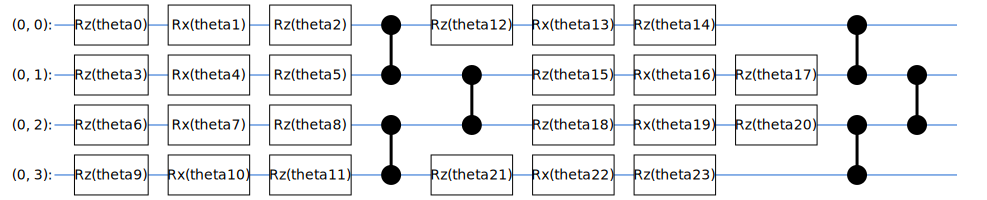

In [3]:
def generate_circuit(nr_of_qubits, layers):
    qubits = cirq.GridQubit.rect(1, nr_of_qubits) # Define qubit grid. In this case 
    nr_parameters = 3*nr_of_qubits*layers # 3 params for each qubit and layer

    symb = sympy.symbols('theta0:'+str(nr_parameters))
    symbols = np.array(symb)
    symbols = symbols.reshape(layers, nr_of_qubits, 3)
    circuit = cirq.Circuit()

    for l in range(layers):
        # Add a series of single qubit rotations.
        for i, qubit in enumerate(qubits):
            circuit += cirq.rz(symbols[l][i][0])(qubit)
            circuit += cirq.rx(symbols[l][i][1])(qubit)
            circuit += cirq.rz(symbols[l][i][2])(qubit)

        circuit += cirq.CZ(qubits[0], qubits[1])
        circuit += cirq.CZ(qubits[2], qubits[3])
        circuit += cirq.CZ(qubits[1], qubits[2])

    op = 1/4*(cirq.X(qubits[0]) + cirq.X(qubits[1]) + cirq.X(qubits[2]) + cirq.X(qubits[3]))         
    return circuit, op, list(symb)

nr_of_qubits = 4
layers = 2
tf_circuit, op, (symbols) = generate_circuit(nr_of_qubits, layers)
SVGCircuit(tf_circuit) 

### Training

This part took me very long to figure out, because the TFQ documentation is mostly focus on training with data. I tried to use the keras.model.fit() functions, but I did not manage to make them work without input data. There is probably some way to do it, but after a few hours I gave up and I do the gradient update manually.

The key in the following part is the function `tfq.layers.Expectation()`. We can give it as an argumnet our circuit, which has to be converted to a tf tensor, the operator that we want to optimize the expectation value of (in our case this is $1-M$). We also need to feed the list of symbols and their current values.

TF finds the grad of this circuit with respect to the parameters in 'symbols'.

The gradient descent update rule is $\theta_i^{t+1} = \theta_i^t - \eta \partial_{\theta_i} f(\theta)$

In [ ]:
circuit_tensor = tfq.convert_to_tensor([tf_circuit])

expectation = tfq.layers.Expectation()

values_tensor = tf.convert_to_tensor(np.random.uniform(0, 2 * np.pi, (1, layers* nr_of_qubits*3 )).astype(np.float32))

eta = 0.1


for i in range(200):
    with tf.GradientTape() as g:
        g.watch(values_tensor)
        forward = expectation(circuit_tensor,
                              operators=1-op,
                              symbol_names=symbols,
                              symbol_values=values_tensor)
        
        if i%10==0:
            print(forward.numpy()[0][0])
        # Return variance of gradients across all circuits.
        grads = g.gradient(forward, values_tensor)
        values_tensor -= eta*grads
        del grads

1.1165314
0.8423661
0.5715227


Like in the Hello World example we can extract the wave function we see that we get the qual superposition state with some global phase.

In [ ]:
simulator = cirq.Simulator()
dictionary = {}
for i in range(len(symbols)):
    symb = symbols[i]
    dictionary[symb] = values_tensor.numpy()[0][i]
resolver = cirq.ParamResolver(dictionary)
resolved_circuit = cirq.resolve_parameters(tf_circuit, resolver)
output_state_vector = simulator.simulate(tf_circuit, resolver).final_state
output_state_vector